# Phase III: First ML Proof of Concept (5\%)

### Team Names:
- Colin Hui
- Derek Aslan
- Aydan Ali
- Conor Cummings

In [161]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import probplot, shapiro

In [ ]:
# function to clean data

def clean_data(original_csv):
    """  
    Cleans the data from the original CSV file by handling missing/null values

    Args:
        original_csv (str): The path to the original CSV file we produced in Phase II.

    Returns:
        pandas.DataFrame: A cleaned DataFrame with missing/null values handled
    """

    df = pd.read_csv(original_csv, index_col=0)

    null_count = df.isnull().sum()
    null_pct = (null_count) / len(df) * 100

    null_df = pd.DataFrame({'null_count': null_count, 'null_pct': null_pct})

    # Drop rows where the target variable 'VA.EST' is null
    df_clean = df.dropna(subset=['VA.EST'])  
    
    # calculating null percentages for each column after removing rows with null target values
    null_pct_clean = (df_clean.isnull().sum()) / len(df_clean) * 100
    
    # finding columns that have more than 40% null values - extract column names and store in a list
    drop_columns = null_pct_clean[null_pct_clean > 40].index.tolist()
    if drop_columns:
        # .drop function to drop columns with more than 40% null values
        df_clean = df_clean.drop(columns=drop_columns)
    
    
    # trying to maximize rows by imputing missing values for remaining columns if there arent a great # of nulls
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            null_pct = df_clean[col].isnull().sum() / len(df_clean) * 100

            if null_pct < 10:
                # median is better to use compared to mean since it is less affected by outliers
                df_clean[col] = df_clean[col].fillna(df_clean[col].median())
            else:
                df_clean = df_clean.dropna(subset = [col])

    
    return df_clean
    

In [121]:
df = clean_data('world_bank_data_2023.csv')
print(df)

    SP.POP.TOTL  NY.GNP.PCAP.CD  MS.MIL.XPND.GD.ZS    VA.EST  \
AO   36749906.0          2130.0           1.332529 -0.737252   
AL    2745972.0          7680.0           1.743992  0.168997   
AR   45538401.0         12890.0           0.472747  0.533922   
AM    2964300.0          6840.0           5.450925  0.076708   
AU   26652777.0         63160.0           1.922199  1.506602   
..          ...             ...                ...       ...   
VE   28300854.0          6720.0           0.500704 -1.531321   
XK    1682668.0          6290.0           1.254180 -0.088809   
ZA   63212384.0          6480.0           0.733137  0.744892   
ZM   20723965.0          1290.0           1.303002 -0.047946   
ZW   16340822.0          2060.0           0.248808 -1.092633   

                        region          incomeLevel  
AO         Sub-Saharan Africa   Lower middle income  
AL       Europe & Central Asia  Upper middle income  
AR  Latin America & Caribbean   Upper middle income  
AM       Europe

### Attempt 1 - Linear Regression

In [220]:
def evaluate_model(X, y):
    """
    Fit a simple linear regression model and evaluate with R^2 and MSE.
    
    Args:
        X (DataFrame or array): Feature values (GDP, Military Spending, Population)
        y (Series or array): Target values (Voice & Accountability)
    
    Returns:
        Trained model with evaluation metrics
    """
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Model evaluation
    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)

    print(f"MSE:: {mse:.4f}")
    print(f"R^2: {r2:.4f}")
    
    y_pred = model.predict(X)
    residuals = y - y_pred

    fig, axes = plt.subplots(1, 4, figsize = (16, 4))

    # independence - residuals vs order
    axes[0].scatter(range(len(residuals)), residuals, alpha=0.5)
    axes[0].axhline(0, color = 'red', linestyle='--')
    axes[0].set_title('Independence: Residuals vs Order', size = 11)
    axes[0].set_xlabel('Index')
    axes[0].set_ylabel('Residuals')

    # Residuals vs Fitted
    axes[1].scatter(y_pred, residuals, alpha = 0.5)
    axes[1].axhline(0, color = 'red', linestyle = '--')
    axes[1].set_title('Homoscedasticity: Residuals vs Fitted', size = 11)
    axes[1].set_xlabel('Fitted Values')
    axes[1].set_ylabel('Residuals')

    # Q-Q plot (Normality)
    probplot(residuals, dist="norm", plot=axes[2])
    axes[2].set_title('Normality: Q-Q Plot')

    # Histogram of residuals (normality)
    axes[3].hist(residuals, bins=20, edgecolor='black', alpha=0.5)
    axes[3].set_title('Normality: Residuals Histogram')
    axes[3].set_xlabel('Residuals')
    axes[3].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return model


MSE:: 0.4214
R^2: 0.5926


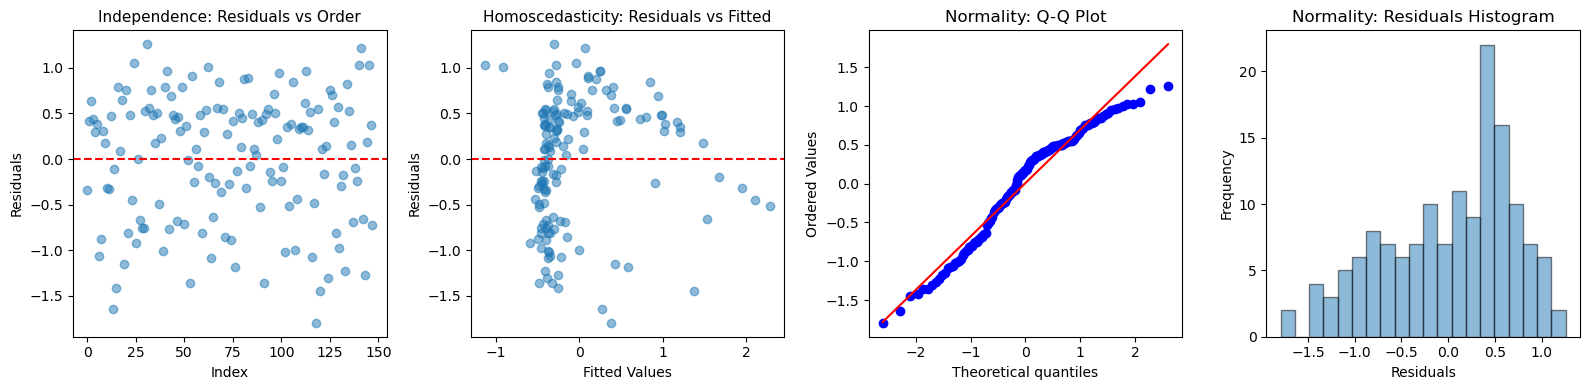

In [221]:
# Define features and target - trying to predict Voice & Accountability from all the other indicators
X = df[['NY.GNP.PCAP.CD', 'MS.MIL.XPND.GD.ZS', 'SP.POP.TOTL']]
y = df['VA.EST']

# Evaluating simple linear regression model
model = evaluate_model(X, y)

### Attempt 2 - Polynomial Regression

Polynomial Regression MSE: 0.6310
Polynomial Regression R^2: 0.3900


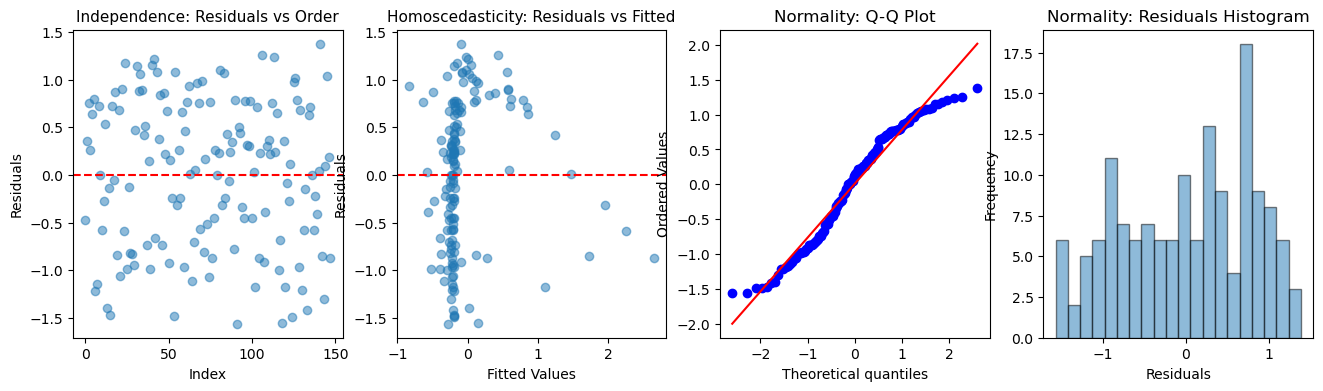

In [238]:
X = df[['NY.GNP.PCAP.CD', 'MS.MIL.XPND.GD.ZS', 'SP.POP.TOTL']]
y = df['VA.EST']

# the 'LinearRegression' function already introduces bias column
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=8)

model = LinearRegression()
model.fit(X_train, y_train)

# get predictions on test set
y_pred_test = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"Polynomial Regression MSE: {mse:.4f}")
print(f"Polynomial Regression R^2: {r2:.4f}")

y_pred = model.predict(X_poly)
residuals = y - y_pred

fig, axes = plt.subplots(1, 4, figsize = (16, 4))   

# independence - residuals vs order
axes[0].scatter(range(len(residuals)), residuals, alpha = 0.5)
axes[0].axhline(0, color = 'red', linestyle='--')
axes[0].set_title('Independence: Residuals vs Order', size = 11)
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Residuals')

# Residuals vs Fitted
axes[1].scatter(y_pred, residuals, alpha = 0.5)
axes[1].axhline(0, color = 'red', linestyle = '--') 
axes[1].set_title('Homoscedasticity: Residuals vs Fitted', size = 11)
axes[1].set_xlabel('Fitted Values')
axes[1].set_ylabel('Residuals')

# Q-Q plot (Normality)
probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Normality: Q-Q Plot')

# Histogram of residuals (normality)
axes[3].hist(residuals, bins=20, edgecolor='black', alpha=0.5)
axes[3].set_title('Normality: Residuals Histogram')
axes[3].set_xlabel('Residuals')
axes[3].set_ylabel('Frequency')



plt.tight_layout
plt.show()

### Extra Attempt: K-nearest neighbors (predicting **'Region'**)

In [239]:
# put the csv back into a DataFrame
df = pd.read_csv('world_bank_data_2023.csv', index_col=0)

# Clean the data and remove rows with missing values for variables we're using
df_clean = df.dropna(subset=['NY.GNP.PCAP.CD', 'VA.EST', 'SP.POP.TOTL', 'MS.MIL.XPND.GD.ZS', 'region'])
df_clean

,SP.POP.TOTL,NY.GNP.PCAP.CD,SI.POV.DDAY,SI.POV.GINI,MS.MIL.XPND.GD.ZS,VA.EST,region,incomeLevel
AO,36749906.0,2130.0,NaN,NaN,1.332529,-0.737252,Sub-Saharan Africa,Lower middle income
AL,2745972.0,7680.0,NaN,NaN,1.743992,0.168997,Europe & Central Asia,Upper middle income
AR,45538401.0,12890.0,1.2,42.4,0.472747,0.533922,Latin America & Caribbean,Upper middle income
AM,2964300.0,6840.0,1.9,27.2,5.450925,0.076708,Europe & Central Asia,Upper middle income
AU,26652777.0,63160.0,NaN,NaN,1.922199,1.506602,East Asia & Pacific,High income
...,...,...,...,...,...,...,...,...
US,336806231.0,80710.0,1.2,41.8,3.361836,0.877519,North America,High income
XK,1682668.0,6290.0,NaN,NaN,1.254180,-0.088809,Europe & Central Asia,Upper middle income
ZA,63212384.0,6480.0,NaN,NaN,0.733137,0.744892,Sub-Saharan Africa,Upper middle income
ZM,20723965.0,1290.0,NaN,NaN,1.303002,-0.047946,Sub-Saharan Africa,Lower middle income


In [240]:
def kNN(k, train_x, train_y, x_real, distance_function):
    """
    Performs a k-nearest-neighbors classification on a data point x_real.
    Args:
        k: the number of neighbors
        train_x: a dataframe containing a set of reference data entries
        train_y: a dataframe containing the corresponding set of classifications for train_x
        x_real: a dataframe containing the target to classify
        distance_function (input1, input2) : a function that returns the distance between two data points.
            Args:
                input1: a dictionary of values corresponding to a data point
                input2: another such dictionary
            Returns:
                distance: a number representing the distance between the data points.

    Returns:
        y_prediction: a predicted classification for x_real
    """

    train_x_dict = train_x.to_dict('index')
    train_y_dict = train_y.to_dict()    
    distances = {}
    for key in train_x_dict.keys():
        distances[key] = distance_function(train_x_dict[key], x_real)
    sorted_distances = sorted(distances.items(), key=lambda item: item[1])
    neighbors = []
    for i in range(k):
        neighbors.append(train_y_dict[sorted_distances[i][0]])
    return max(set(neighbors), key=neighbors.count)

In [241]:
def kNN_Simple(k, x_real):
    """
    A simplified version of kNN which automatically selects the training data and distance function.
    Args:
        k: the number of neighbors
        x_real: a dataframe containing the target to classify

    Returns:
        y_prediction: a predicted classification for x_real
    """
    return kNN(
        k,
        df_clean.loc[:, ['SP.POP.TOTL', 'NY.GNP.PCAP.CD', 'MS.MIL.XPND.GD.ZS', 'VA.EST']],
        df_clean.loc[:, 'region'],
        x_real,
        dist_function
    )

In [242]:
def dist_function(input1, input2):
    """
    Computes the distance between two data points for a kNN classifier.
    Args:
        input1: a dictionary of values corresponding to a data point
        input2: another such dictionary
    Returns:
        distance: a double representing the distance between the data points.
    """
    distDict = {
        'SP.POP.TOTL': (input1['SP.POP.TOTL'] - input2['SP.POP.TOTL']) / df_clean.std(numeric_only = True)['SP.POP.TOTL'],
        'NY.GNP.PCAP.CD': (input1['NY.GNP.PCAP.CD'] - input2['NY.GNP.PCAP.CD']) / df_clean.std(numeric_only = True)['NY.GNP.PCAP.CD'],
        'MS.MIL.XPND.GD.ZS': (input1['MS.MIL.XPND.GD.ZS'] - input2['MS.MIL.XPND.GD.ZS']) / df_clean.std(numeric_only = True)['MS.MIL.XPND.GD.ZS'],
        'VA.EST': (input1['VA.EST'] - input2['VA.EST']) / df_clean.std(numeric_only = True)['VA.EST'],
    }

    return (distDict['SP.POP.TOTL']**2 + distDict['NY.GNP.PCAP.CD']**2 + distDict['MS.MIL.XPND.GD.ZS']**2 + distDict['VA.EST']**2) ** 0.5

In [243]:
kNN(5, df_clean.loc[:, ['SP.POP.TOTL', 'NY.GNP.PCAP.CD', 'MS.MIL.XPND.GD.ZS', 'VA.EST']], df_clean.loc[:, 'region'], df_clean.loc['AL', ['SP.POP.TOTL', 'NY.GNP.PCAP.CD', 'MS.MIL.XPND.GD.ZS', 'VA.EST']], dist_function)

'Europe & Central Asia'

In [244]:
kNN_Simple(6, df_clean.loc['AL', ['SP.POP.TOTL', 'NY.GNP.PCAP.CD', 'MS.MIL.XPND.GD.ZS', 'VA.EST']])

'Europe & Central Asia'